### Torus Geometry
- **Triangular unit cell**: Primitive vectors G₁ = (G, 0), G₂ = (-G/2, √3G/2)
- **Landau level**: n = 0 (lowest Landau level)
- **Brillouin zone area**: 2π/l² = √0.75 × G²
- **Magnetic length**: l = √(ℏ/eB) sets the length scale

### Filling Factor
- **ν**: Filling factor 1/3 or others (Laughlin state)
- **Nk**: Number of k-points must be multiple of m for commensurability
- **Ne = Nk * ν**: Number of electrons for ν filling

### Interaction Details
- **Form factor**: V(q) = W₀ × 1/|ql| × tanh(|qD|)
- **Screening**: D/l (finite screening length)
- **Landau level projection**: exp(-0.5 × q²l²) form factor
- **Units**: Energy in units of W₀, length in units of magnetic length l

### Key Physics
- **Magnetic translation algebra**: Implements proper commutation relations
- **Periodic boundary conditions**: Torus geometry with modular parameter τ
- **Momentum conservation**: Total momentum K = (K₁, K₂) is conserved
- **Ground state degeneracy**: m-fold degenerate on torus for Laughlin states

In [1]:
# Define 3×5 k-mesh (Nk=15) for 1/3 filling Laughlin state calculation
k_list = [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4]

# System parameters
Nk = 15         # Total number of k-points
Gk = (3, 5)     # Grid dimensions (G1_direction, G2_direction)
Ne = 5          # Ne electrons for this system, Ne=5 for 1/3 filling, Ne=3 for 1/5 filling

5

In [2]:
# Define k-mesh for triangular lattice
# Using 9×9 k-mesh (Nk=27) for accurate Laughlin state calculation
# Note: This setup needs much more time and memory

#=

k_list = [0 3 6 2 5 8 1 4 7 0 3 6 2 5 8 1 4 7 0 3 6 2 5 8 1 4 7;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]

# System parameters
Nk = 27          # Total number of k-points
Gk = (9, 9)      # Grid dimensions (G1_direction, G2_direction)
@assert iszero(mod(Nk, 3))  # Ensure commensurability
m = 3            # Denominator of filling factor ν = 1/m
# Number of electrons for 1/3 filling
Ne = Nk ÷ m      # N electrons for this system

=#

In [3]:
# Define k-mesh for triangular lattice
# Using 6×5 k-mesh (Nk=30) for accurate Laughlin state calculation
# Note: This setup needs much more time and memory
# Note: for 10/30 filling, 36GB memory is recommended

#=

k_list = [0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5;
          0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4]

# System parameters
Nk = 30         # Total number of k-points
Gk = (6, 5)      # Grid dimensions (G1_direction, G2_direction)
Ne = 10         # N electrons for this system

#

Base.Meta.ParseError: ParseError:
# Error @ c:\Users\zoubo\PhysicsWorking\MomentumED.jl\examples\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl:6:1

┌─
#=

⋮

#
┘ ── unterminated multi-line comment #= ... =#

In [4]:
# Import the momentum-conserved exact diagonalization package
using MomentumED

# Physical parameters for the FQH system
Gl = sqrt(2π/sqrt(0.75))  # Magnetic length scale from Brillouin zone area
D_l = 5.0                  # Screening length / magnetic length (D/l = 5)
W0 = 1.0                   # Interaction strength (energy unit)
G12_angle = 2π/3          # Angle between reciprocal lattice vectors (triangular lattice)

# Define the form factor for Coulomb interaction in Landau level
# This is the Fourier transform of the projected Coulomb interaction
# V(q) = W₀ * 1/|ql| * tanh(|qD|) * exp(-0.5 * q²l²)
# The exp(-0.5 * q²l²) factor comes from Landau level projection
function VFF(q1::Float64, q2::Float64)
    ql = sqrt(q1^2 + q2^2 + 2cos(G12_angle) * q1*q2) * Gl  # |q| in magnetic length units
    if ql == 0.0
        return W0 * D_l  # Regularization at q=0 (divergent part)
    end
    return W0 / ql * tanh(ql * D_l) * exp(-0.5 * ql^2)
end

# Sign function for reciprocal lattice vectors
# This implements the phase structure of the magnetic translation group
# The sign depends on the parity of the reciprocal lattice vector indices
function ita(g1::Int64, g2::Int64)
    if iseven(g1) && iseven(g2)
        return 1
    else
        return -1
    end
end

# Cross product for 2D vectors (returns scalar z-component)
# Used for computing geometric phases in the magnetic translation algebra
function ql_cross(q1_1, q1_2, q2_1, q2_2)
    return q1_1 * q2_2 - q1_2 * q2_1
end

# Two-body interaction matrix element
# This implements the full Coulomb interaction with proper magnetic translation phases
# The interaction is computed in momentum space with Landau level projection
# Momentum inputs are Tuple(Float64, Float64) representing (k1, k2) in ratio of Gk
function V_int(kf1, kf2, ki2, ki1, cf1=1, cf2=1, ci2=1, ci1=1; output=false)::ComplexF64
    
    # Calculate momentum transfer (modulo reciprocal lattice)
    q = rem.(ki1 .- kf1, 1, RoundNearest)
    G_shift1 = round.(Int64, ki1 .- kf1 .- q, RoundNearest)
    G_shift2 = round.(Int64, kf2 .- ki2 .- q, RoundNearest)

    V_total = ComplexF64(0.0)
    # Sum over reciprocal lattice vectors for convergence
    # Nshell = 2 provides good convergence for this system
    Nshell = 2
    for g1 in -Nshell:Nshell, g2 in -Nshell:Nshell
        if abs(g1-g2) > Nshell
            continue
        end

        # Construct the full momentum transfer including reciprocal lattice
        qq1 = q[1] + g1
        qq2 = q[2] + g2

        # Calculate phase factors from magnetic translation algebra
        # These phases ensure proper commutation relations and gauge invariance
        phase_angle = 0.5ql_cross(ki1[1], ki1[2], kf1[1], kf1[2])
        phase_angle += 0.5ql_cross(ki1[1]+kf1[1], ki1[2]+kf1[2], qq1, qq2)
        phase_angle += 0.5ql_cross(ki2[1], ki2[2], kf2[1], kf2[2])
        phase_angle += 0.5ql_cross(ki2[1]+kf2[1], ki2[2]+kf2[2], -qq1, -qq2)

        phase = cispi(2.0phase_angle)
        sign = ita(g1+G_shift1[1], g2+G_shift1[2]) * ita(g1+G_shift2[1], g2+G_shift2[2])

        V_total += sign * phase * VFF(qq1, qq2)
    end

    return V_total
end

# Create parameter structure for the exact diagonalization
# This contains all the system information needed for the calculation
para = EDPara(k_list = k_list, Gk = Gk, V_int = V_int);

In [5]:
blocks, block_k1, block_k2, k0number = 
    ED_momentum_block_division(para, ED_mbslist(para, (Ne,)));
length.(blocks)

15-element Vector{Int64}:
 201
 200
 200
 200
 200
 201
 200
 200
 200
 200
 201
 200
 200
 200
 200

In [6]:
scat_list1 = ED_sortedScatteringList_onebody(para);
scat_list2 = ED_sortedScatteringList_twobody(para);

In [7]:
Neigen = 5  # Number of eigenvalues to compute per block
energies = Vector{Vector{Float64}}(undef, length(blocks))
vectors = Vector{Vector{Vector{ComplexF64}}}(undef, length(blocks))
for i in eachindex(blocks)
    println("Processing block #$i with size $(length(blocks[i])), momentum $(block_k1[i]), $(block_k2[i])")
    energies[i], vectors[i] = EDsolve(blocks[i], scat_list1, scat_list2, Neigen;
    showtime=true, converge_warning = false, tol = 1e-5)
end

Processing block #1 with size 201, momentum 0, 0
  0.188616 seconds (458.08 k allocations: 17.435 MiB, 600.87% compilation time)
  0.308541 seconds (726.41 k allocations: 38.009 MiB, 2.17% gc time, 288.67% compilation time)
Processing block #2 with size 200, momentum 0, 1
  0.003541 seconds (200.02 k allocations: 4.688 MiB)
  0.001600 seconds (1.36 k allocations: 670.752 KiB)
Processing block #3 with size 200, momentum 0, 2
  0.019144 seconds (200.05 k allocations: 4.688 MiB, 82.54% gc time)
  0.003318 seconds (1.12 k allocations: 550.408 KiB)
Processing block #4 with size 200, momentum 0, 3
  0.003871 seconds (200.01 k allocations: 4.687 MiB)
  0.001630 seconds (1.12 k allocations: 549.908 KiB)
Processing block #5 with size 200, momentum 0, 4
  0.002865 seconds (200.03 k allocations: 4.687 MiB)
  0.001341 seconds (1.36 k allocations: 671.143 KiB)
Processing block #6 with size 201, momentum 1, 0
  0.003927 seconds (201.66 k allocations: 4.736 MiB)
  0.002811 seconds (1.19 k allocations

In [8]:
# The package for plotting is not included in this package. Use the following to add it:
# using Pkg; Pkg.add("CairoMakie")

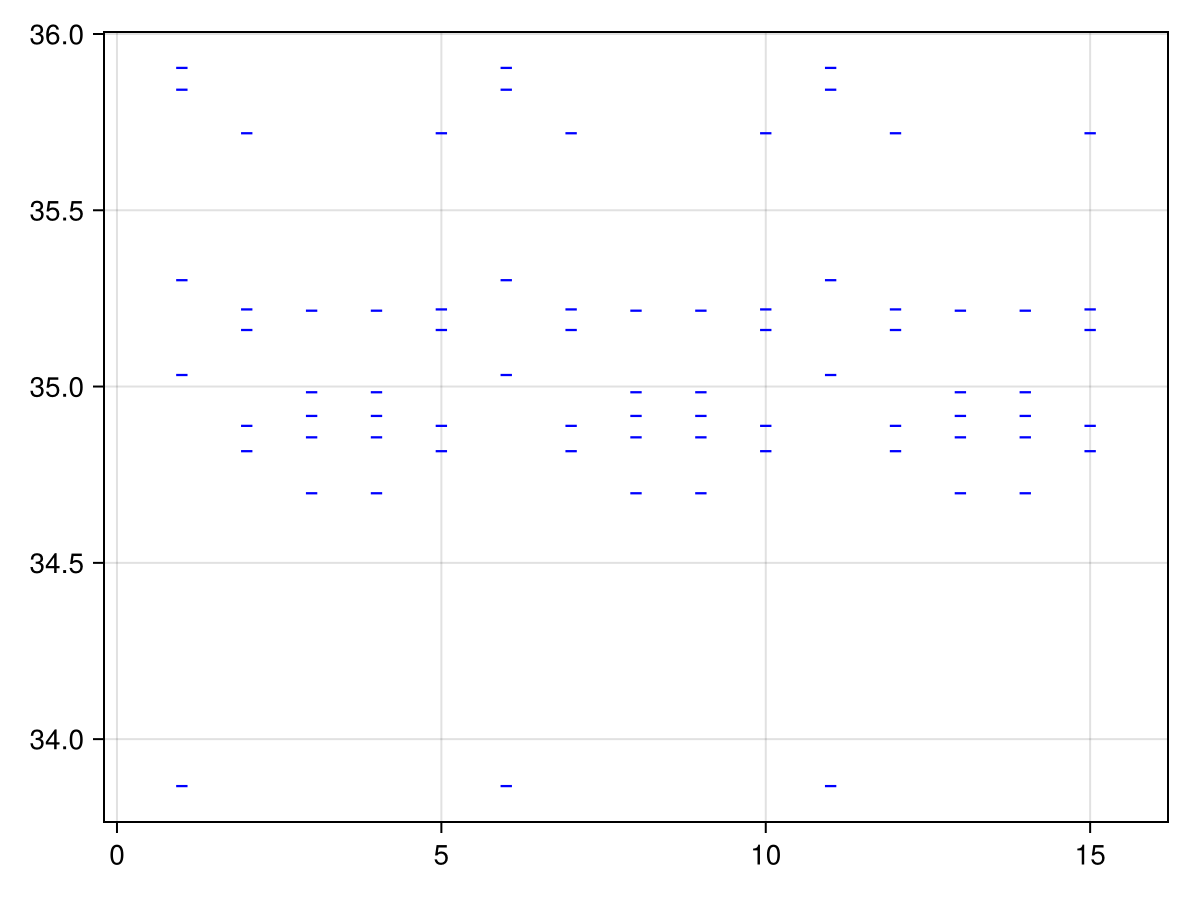

In [9]:
# Plot the energy spectrum
using CairoMakie
CairoMakie.activate!()
begin
    fig = Figure();
    ax = Axis(fig[1, 1])
    for i in 1:length(blocks)
        for e in energies[i]
            scatter!(ax, i, e, color = :blue, marker=:hline)
        end
    end
    xlims!(-0.2, 1.2+length(blocks))
    fig
end

In [15]:
# check energies explicitly to see if there's degeneracy in the same momentum sector.
bn = 1 # the block number to inspect
energies[bn]

5-element Vector{Float64}:
 33.86682438611355
 35.03275801926242
 35.30167296394194
 35.841913569851386
 35.903774936329384

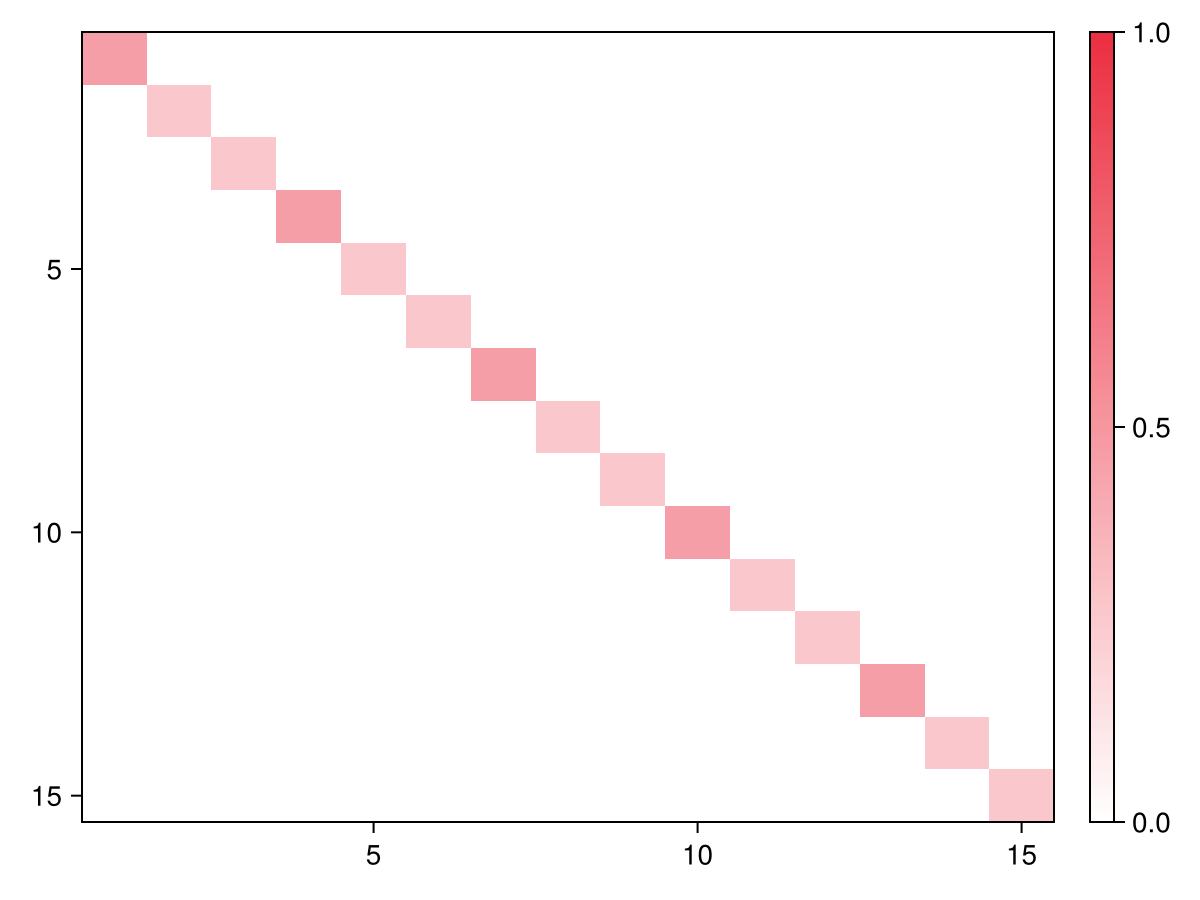

In [16]:
# plot the one-body reduced density matrix of the ground eigenstate in the first block
rdm = ED_onebody_rdm(blocks[bn], vectors[bn][1])
begin
    fig = Figure();
    ax = Axis(fig[1, 1]; yreversed = true)
    hm = heatmap!(ax, abs.(rdm); colorrange = (0,1), 
        colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
    )
    Colorbar(fig[1, 2], hm)
    fig
end

Do momentum shift and find the many-body connection and Chern number.

In [26]:
psi_before = copy(vectors[bn][1])
psi_before *= cis(-angle(psi_before[1]))  # fix global phase

N_shift = 3  # number of shifts along each edge
shifts = Tuple{Float64, Float64}[]
for i in 1:N_shift
    push!(shifts, (i/N_shift, 0.0))
end
for i in 1:N_shift
    push!(shifts, (1.0, i/N_shift))
end
for i in 1:N_shift
    push!(shifts, ((N_shift - i)/N_shift, 1.0))
end
for i in 1:N_shift
    push!(shifts, (0.0, (N_shift - i)/N_shift))
end
shifts

12-element Vector{Tuple{Float64, Float64}}:
 (0.3333333333333333, 0.0)
 (0.6666666666666666, 0.0)
 (1.0, 0.0)
 (1.0, 0.3333333333333333)
 (1.0, 0.6666666666666666)
 (1.0, 1.0)
 (0.6666666666666666, 1.0)
 (0.3333333333333333, 1.0)
 (0.0, 1.0)
 (0.0, 0.6666666666666666)
 (0.0, 0.3333333333333333)
 (0.0, 0.0)

In [27]:
function BerryConnectionStepIntegral(k, shift_in, shift_out)
    dk = shift_out .- shift_in
    k = Tuple(k) .+ shift_in
    return -π * (k[1]*dk[2] - k[2]*dk[1])
end
function ManybodyConnectionStepIntegral(psi_in, psi_out, block, shift_in, shift_out, para)
    mbc = 0.0
    for x in eachindex(block)
        if abs(psi_in[x]) > 1e-8 && abs(psi_out[x]) > 1e-8
            coeffi = conj(psi_out[x]) * psi_in[x]
            i_list = MomentumED.occ_list(block[x])
            bc = sum(i_list) do i
                BerryConnectionStepIntegral(para.k_list[:,i] ./ para.Gk, shift_in ./ para.Gk, shift_out ./ para.Gk)
            end
            mbc += coeffi * cis(bc)
        end
    end
    println("mbc: amp=$(abs(mbc)), angle=$(angle(mbc))")
    return angle(mbc)
end

ManybodyConnectionStepIntegral (generic function with 1 method)

In [28]:
connectionIntegral = similar(shifts, Float64)
for i in eachindex(shifts)
    println("k_shift #$i \t $(shifts[i])")

    scat_list1 = ED_sortedScatteringList_onebody(para);
    scat_list2 = ED_sortedScatteringList_twobody(para; kshift = shifts[i]);
    psi_after = EDsolve(blocks[bn], scat_list1, scat_list2, 1;
        showtime=true, converge_warning = false
    )[2][1]
    psi_after *= cis(-angle(psi_after[1]))  # fix global phase

    mbc = ManybodyConnectionStepIntegral(psi_before, psi_after, blocks[bn], i==1 ? (0.0,0.0) : shifts[i-1], shifts[i], para)
    connectionIntegral[i] = mbc

    psi_before = psi_after
end
sum(connectionIntegral) / (2π)

k_shift #1 	 (0.3333333333333333, 0.0)
  0.003301 seconds (201.67 k allocations: 4.737 MiB)
  0.001758 seconds (670 allocations: 385.932 KiB)
mbc: amp=0.9276830742331188, angle=-0.3490658503988558
k_shift #2 	 (0.6666666666666666, 0.0)
  0.008751 seconds (201.67 k allocations: 4.736 MiB, 67.98% gc time)
  0.002174 seconds (673 allocations: 385.900 KiB)
mbc: amp=0.9276830742331184, angle=-0.3490658503988765
k_shift #3 	 (1.0, 0.0)
  0.003673 seconds (201.65 k allocations: 4.707 MiB)
  0.000954 seconds (670 allocations: 386.229 KiB)
mbc: amp=0.9276830742331184, angle=-0.3490658503988656
k_shift #4 	 (1.0, 0.3333333333333333)
  0.002453 seconds (201.66 k allocations: 4.736 MiB)
  0.003462 seconds (668 allocations: 385.807 KiB)
mbc: amp=0.8611710067476912, angle=-0.2623943935902957
k_shift #5 	 (1.0, 0.6666666666666666)
  0.004951 seconds (201.66 k allocations: 4.736 MiB, 48.06% gc time)
  0.000909 seconds (668 allocations: 385.822 KiB)
mbc: amp=0.8611710067476895, angle=-0.262394393590311

-0.3333333333333328